# Reading and Processing Data from STAC

We will query a STAC catalog for Sentinel-2 imagery and load a single image using XArray. We will also apply some data processing to clip the image and calculate spectral indices.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas folium stackstac rioxarray mapclassify

In [ ]:
import json
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import pystac_client
import os
import folium
from folium import Figure
import stackstac
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import mapclassify
import numpy as np

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'bangalore.geojson')

## Procedure

Let's use Element84 search endpoint to look for items from the sentinel-2-l2a collection on AWS

In [ ]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

In [ ]:
aoi_file = 'bangalore.geojson'
aoi_filepath = os.path.join(data_folder, aoi_file)
aoi = gpd.read_file(aoi_filepath)

In [ ]:
geometry = aoi.unary_union
geometry_geojson = json.dumps(mapping(geometry))

In [ ]:
year = 2023
month = 5
time_range = f'{year}-{month:02}'

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    intersects=geometry_geojson,
    datetime=time_range,
    query={'eo:cloud_cover': {'lt': 30},  'mgrs:grid_square': {'eq': 'GQ'}},
)
items = search.item_collection()
len(items)

In [ ]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
items_df

In [ ]:
fig = Figure(width=800, height=400)
m = folium.Map()
bounds = items_df.total_bounds
m.fit_bounds([[bounds[1],bounds[0]], [bounds[3],bounds[2]]])

items_df.explore(m=m,
                 color='black',
                 tooltip=['created'],
                 style_kwds={'fillOpacity': 0.2, 'weight': 0.5},)
aoi.explore(m=m, color='blue')
fig.add_child(m)


In [ ]:
stack = stackstac.stack(items, resolution=10)
stack

In [ ]:
scene = stack.isel(time=0).sel(band=['red', 'green', 'blue', 'nir', 'swir16', 'scl'])
scene

In [ ]:
geometry = aoi.to_crs(scene.rio.crs).geometry
clipped = scene.rio.clip(geometry)
clipped

In [ ]:
%time clipped = clipped.compute()

In [ ]:
rgb = clipped.sel(band=['red', 'green', 'blue'])

C:\Users\ujava\anaconda3\envs\eocloud\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


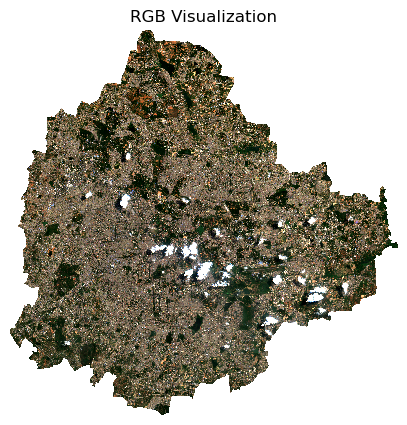

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
rgb.plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

Apply a cloud-mask using the SCL (Scene Classification Map) band.

In [ ]:
scl = clipped.sel(band='scl')

valid = ((scl >= 4) & (scl <= 7) | (scl==11))
         
clipped_masked = clipped.where(valid)
rgb_masked = clipped_masked.sel(band=['red', 'green', 'blue'])

C:\Users\ujava\anaconda3\envs\eocloud\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


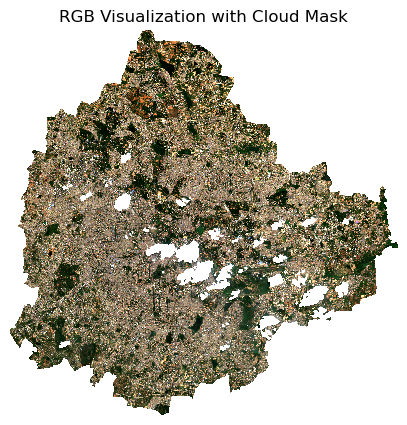

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
rgb_masked.plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization with Cloud Mask')
ax.set_axis_off()
plt.show()

In [ ]:
red = clipped_masked.sel(band='red')
nir = clipped_masked.sel(band='nir')
green = clipped_masked.sel(band='green')
swir1 = clipped_masked.sel(band='swir16')

mndwi = (green - swir1)/(green + swir1)
ndvi = (nir - red)/(nir + red)

In [ ]:
%%time

date_string = str(scene.time.dt.strftime('%Y_%m').values)

files = {
    f'rgb_{date_string}.tif': rgb,
    f'rgb_{date_string}_masked.tif': rgb_masked,
    f'ndvi_{date_string}.tif': ndvi,
    f'mndwi_{date_string}.tif': mndwi
}

for file in files:
  output_path = os.path.join(output_folder, file)
  files[file].rio.to_raster(output_path, driver='COG')
  print(f'Wrote {file}')